In [62]:
from math import *
import numpy as np
from matplotlib import pyplot as plt

# Carbon Precision Considerations -- DRAFT

## Storage requirements for A,B

### Prices

We are here discussing the storage requirements for crypto prices. Prices have the following components

- **Precision**: in traditional financial markets we usualy want prices to be quoted with 5 significant digits, which corresponds to a range of $10^6$ or $3.3*6 \simeq 20$ bits.

- **Range**: in crypto, the price ranges is rather wide; against the USD alone, we need to contemplate at least $10^5$ on the upside (BTC) and $10^{-5}$ on the downside (SHIB). If we use BTC/SHIB as an example this means a range of at least $10^{10}$, and we need to double this range to $10^{20}$ to account for reverse quotation of the price. This gives use $20*3.2 \simeq 64$ bits on the range.

- **Decimals**: a pecularity in crypto is that display prices are not _real_ prices because of decimality: what matters when exchanging two tokens is not the display price, but the price of the underlying _token-wei_. Most tokens are 18 decimals, some important ones (stable coins in particular) are 6 decimals. A very small number of tokens has 24 decimal, and a few hundred have between 6 and 0. A decimality difference of 12 (18/6) corresponds to $12*3.3 \simeq 40$ bits, and difference of 18 (18/0 or 24/6) corresponds to $18*3.3 \simeq 60$ bits. We do not consider the 24/0 case relevant because of the small number of tokens concerned.  

Summing up the bits gives us 20 for precision, 64 for ranges, and 40 or 60 for decimals, yielding a **total of 124 or 144 bits**. We could probably shave a few bits off when looking at the correlation between the factors -- eg low decimality tokens may have low prices to compensate -- but this is a refinement that is outside the scope of the current analysis.

#### Trimming down the 18/6 and 18/18 cases
One simplification we however want to make is to assume that in the 18/6 case we do not have to cover the full range of possible prices, ie we assume that the only meaningful cases we need to cover in 18/6 are stable coins. So we have the two following case

- **18/18**: on 18/18 tokens we need to support the full range of prices; this means 20 bits for precision and 64 bits for range, ie **a total of 84 bits**

- **18/6**: on 18/6 tokens we assume that our price range is only $10^{5}$, essentially SHIB/USDC. So in this case we need 20 bits for precision, 32 bits for range, and 40 bits for decimals, ie a **total of 92 bits**.

In [4]:
log2(10)

3.321928094887362

### The coefficients A,B

The coefficients B, A are defined as $B=\sqrt{P_b}$ and $A=\sqrt{P_a}-\sqrt{P_b}$ respectively. We note first that this means that on the face of it, the number of bits required are half those of prices, so we'd get 62 or 72 respectively. We however need to point out that the "precision" is not equally distributed along the range. Naive considerations may lead to the result that, because the relationship between $b$ and $P_b$ is quadratic, the precision gets worse for bigger prices. The reality however is the other way round, the reason being that we have to look at relative price changes. For those we get:

$$
\frac{\Delta P} P = \frac {(b+1)^2}{b^2} = \frac {2 + 1/b} b \simeq \frac 2 {\sqrt P}
$$



In average, we get the following requirements for the number of bits needed

- For the full case 62 (or 72) bit
- For the 18/18 case 42 bit
- For the 18/6 case 46 bit


However, this is only true _in average_. The problem is that a lot of those grid points will be located towards the higher prices, and they will be very sparse toward the low prices. So whilst the above resolutions may be correct _in average_ they may not be sufficient across the entire range.

We will for the time being ignore the fact that A is not actually the square root of a price, but the _difference_ of two such square roots, but we do note that this may yield _increased_ requirements for the precision of the numbers concerned.

Below we estimate the grid size we get at the lower end of the price range. The number plotted is $P(b+1)/P(b)-1$, ie the percentage change between two adjacent values of $b$ [eg $10^{-2}=1\%$]. We see that it goes linear in a log / log plot. If we want a 1% price grid we are at about $b=200$, and for a 1bp price grid at about $b=20,000$.

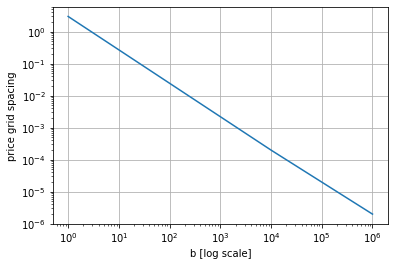

In [88]:
b_r = np.linspace(1,1e6,100)
plt.plot(b_r, [(b+1)**2/b**2 - 1 for b in b_r])
#plt.ylim(0,1)
plt.xlabel("b [log scale]")
plt.ylabel("price grid spacing")
plt.yscale("log")
plt.xscale("log")
plt.grid()

Expressing this in numbers of bits gives us about 8 bits for 1% price accuracy, 11 bits for 10bp accuracy, and 14 bits for 1bp.

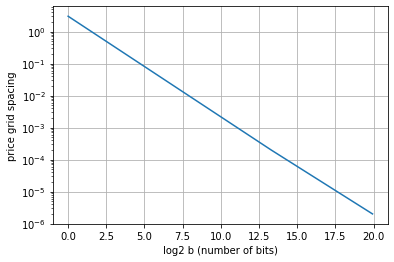

In [87]:
b_r = np.linspace(1,1e6,100)
plt.plot(np.log2(b_r), [(b+1)**2/b**2 - 1 for b in b_r])
plt.xlabel("log2 b (number of bits)")
plt.ylabel("price grid spacing")
plt.yscale("log")
plt.grid()

### The scaling factor

Last but not least we need to keep the scaling in mind. When trading by source, we are using the following equation


$$
\Delta x = \frac 1 {s^2} \cdot \frac{\Delta y\, (ay+bz)^2}{\Delta y\, a(ay+bz)+z^2 s^2} 
$$

and when we are trading by target the following equation

$$
\Delta y = \frac{\Delta x\, s^2 z^2}{(ay+bz)(ay+bz+a\Delta x)} 
$$

in both cases the coefficient $s$ is a scaling factor, which we currently set to

$$
s = 2^{x_s} = 2^{32}
$$

The number of bits required for the scaling factor is $x_s$, which in the current implementation is 32 bits. 

The interaction between the scaling factor and the above numbers is somewhat complex -- essentially the scaling factor is there to (a) allow for numbers < 1 to be transmitted into the contract, and to (b) scale the numerator of the above equations to a multiple of its denominator. So there is a certain amount of double counting here, but it is not entirely clear how much. **We assume for the time being full double counting, ie we do not consider any extra size requirements due to the scaling factor.** We believe this to make sense, but we do need to point out this is an aggressive assumption, and that we may need to revise it at a later stage.

### Conclusion

We have shown above that only about 20 bits are required to obtain a reasonable resolution of $10^{-5}$ on the prices, both via direct estimation and by looking at the charts. The remainder of those bits -- ie the largest portion of the requirement -- is because of scaling. This is similar in the decimal case to a situation where we have eg 1.2345 vs 0.00000012345 vs 12,345,000,000. It is well known that the most efficient way to represent numbers with constant precision requirements across a wide scale _in storage_ is through a floating point representation. Here specifically we could go for a _storage_ representation of

$$
b = 2^{x_b} \cdot b_0
$$

with $b_0$ being a 20 bit number (for precision) and the exponent $x_b$ being well inside an 8 bit range. If we are generous, we can increase the storage size of $b_0$, but a value of 40 should be plenty. We want to stress here that this representation only applies for the storage considerations of those coefficients. **For actual calculations within the EVM they will be expanded to regular 256 bit integers.**

## Scaling factor

The optimal choice of the scaling factor is driven by two competing requirements. 

1. **Granularity**. The numbers a,b must be big enough that the above _trade by source_ and _trade by target_ equations read sensible results without too much rounding errors. A necessary -- but probably not sufficient -- precondition for this is that the truncated representation of the prices is close enough to the prices desired by the user. In other words -- the price grid spanned by the prices generated by the discrete values of $a,b$ must be sufficiently dense at all relevant price points (this is addressed in the charts above)

2. **Overflow**. At the opposite end of the spectrum lies the overflow risk: throughout the calculation, all numbers obtained must fit into 256 bit unsigned integers (see the pseudo code below for details). Our preliminary analysis suggests that currently usually the binding constraint is the trade by target function, and specifically the term `temp2*temp3`. This term is effectively proportional to $s^2 z^2 \sqrt P$ where $P$ is some reference price level for the range.

We currently have a scaling factor of 32, and an associated representation of $a,b$ as 64 bit integers. A scaling factor of 32 seems to be a good compromise that works in many of the situations we have studied. However, we have found issues arising in particular in the case of SHIB/USDC where the decimality is 18/6 and the price is of the order of $10^{-5}$. We are now proposing the increase the scaling factor to $2^{40}$ _for all curves_ and commensurately increase the storage of a,b to 80 bits.

**Having looked at the 40 bit proposal we have found no obvious cases where (a) it goes wrong, and (b) that matters. In other words: we have established some boundaries of this approach, but the boundaries we have established seem to be acceptable at this state.** It is important however to understand that the fixed format for storing $a,b$ is not well adapted to the problem it hand, so it is clear that it _will_ break, and as pointed out above we have established some boundaries where it breaks alreadly. At the moment it looks like those areas are outside the region that we want Carbon to cover. However -- **this is not a high confidence assessment and there is a non-negligible risk of running into cases where it breaks and that we expected Carbon to cover.**

## Pseudo code

### Data storage and constants

In [1]:
MAX = 2 ** 112

In [ ]:
def readStorage():
    y   = read("y")
    z   = read("z")
    A   = read("A")
    B   = read("B")
    xs  = read["xs"]
    xa  = read["xa"]
    xb  = read["xb"]

    s  = 2**xs
    a *= 2**xa
    b *= 2**xb
    return y,z,A,B,s

### Trade by source


In [ ]:
def getTradeTargetAmount_bySource(x):

    y,z,A,B,s = readStorage()
    ONE = s
    temp1 = y * A + z * B               # 177 bits at most; cannot overflow
    temp2 = temp1 * x / ONE             # 224 bits at most; can overflow; some precision loss
    temp3 = temp2 * A + z * z * ONE     # 256 bits at most; can overflow
    res = mulDiv(temp1, temp2, temp3)
    assert res < MAX
    return res

### Trade by target

note: in practice, the term `temp2*temp3` is the most likely to overflow across both functions.


In [ ]:
def getTradeSourceAmount_byTarget(x):

    y,z,A,B,s = readStorage()
    ONE = s
    temp1 = z * ONE                                 # 144 bits at most; cannot overflow
    temp2 = y * A + z * B                           # 177 bits at most; cannot overflow
    temp3 = temp2 - x * A                           # 177 bits at most; can underflow
    res = mulDiv(x * temp1, temp1, temp2 * temp3)   # each multiplication can overflow
    assert res < MAX
    return res

## Some calculations

In [34]:
b = lambda P, xs, dd=0: int(sqrt(P*(10**dd))*2**int(xs))
p = lambda b, xs, dd=0: (b/2**xs/10**dd)**2
l2b = lambda P, xs, dd=0: log2(b(P, xs, dd))

In [37]:
XS, DD = 40, 0
P = 1e10
b(P, XS, DD), l2b(P, XS, DD), p(b(P, XS, DD), XS, DD), p(b(P, XS, DD)+1, XS, DD)

(109951162777600000, 56.60964047443681, 10000000000.0, 10000000000.0)

In [35]:
p(b(P, XS, DD), XS, DD)

10000000000.0

In [33]:
b(P, XS, DD)

109951162777600000

In [26]:
XS, DD = 40, 12
P = 1e10
b(P, XS, DD), l2b(P, XS, DD)

(109951162777600000000000, 76.54120904376099)

In [38]:
XS, DD = 40, 0
P = 1e-10
b(P, XS, DD), l2b(P, XS, DD), p(b(P, XS, DD), XS, DD), p(b(P, XS, DD)+1, XS, DD)

(10995116, 23.390359489117646, 9.99999949475751e-11, 1.000000131374695e-10)

In [39]:
XS, DD = 40, 0
P = 1e-11
b(P, XS, DD), l2b(P, XS, DD), p(b(P, XS, DD), XS, DD), p(b(P, XS, DD)+1, XS, DD)

(3476961, 21.72939545421481, 9.999999668610526e-12, 1.0000005420760813e-11)

In [40]:
XS, DD = 40, 0
P = 1e-12
b(P, XS, DD), l2b(P, XS, DD), p(b(P, XS, DD), XS, DD), p(b(P, XS, DD)+1, XS, DD)

(1099511, 20.06843060695595, 9.999988580824342e-13, 1.0000006770716264e-12)

In [41]:
XS, DD = 40, 0
P = 1e-15
b(P, XS, DD), l2b(P, XS, DD), p(b(P, XS, DD), XS, DD), p(b(P, XS, DD)+1, XS, DD)

(34769, 15.085513953494843, 9.999648790571429e-16, 1.0000224003697592e-15)

In [44]:
XS, DD = 40, 0
P = 1e-15
b(P, XS, DD), l2b(P, XS, DD), p(b(P, XS, DD), XS, DD), p(b(P, XS, DD), XS, DD)/p(b(P, XS, DD)+1, XS, DD)-1

(34769, 15.085513953494843, 9.999648790571429e-16, -5.752002414649571e-05)

In [46]:
XS, DD = 40, -12
P = 1e-10
b(P, XS, DD), l2b(P, XS, DD), p(b(P, XS, DD), XS, DD), p(b(P, XS, DD)+1, XS, DD)

(10, 3.321928094887362, 82.71806125530277, 100.08885411891634)

In [47]:
XS, DD = 40, -12
P = 1e-8
b(P, XS, DD), l2b(P, XS, DD), p(b(P, XS, DD), XS, DD), p(b(P, XS, DD)+1, XS, DD)

(109, 6.768184324776926, 9827.732857742521, 10008.885411891635)

In [48]:
XS, DD = 40, -12
P = 1e-7
b(P, XS, DD), l2b(P, XS, DD), p(b(P, XS, DD), XS, DD), p(b(P, XS, DD)+1, XS, DD)

(347, 8.43879185257826, 99599.9903768975, 100174.88090262187)

In [50]:
XS, DD = 40, -12
P = 1e-6
b(P, XS, DD), l2b(P, XS, DD), p(b(P, XS, DD), XS, DD), p(b(P, XS, DD)+1, XS, DD)

(1099, 10.101975670949232, 999069.5710221594, 1000888.5411891635)

In [53]:
XS, DD = 40, -12
P = 1e-10
b(P, XS, DD), l2b(P, XS, DD), p(b(P, XS, DD), XS, DD), p(b(P, XS, DD), XS, DD)/p(b(P, XS, DD)+1, XS, DD)-1

(10, 3.321928094887362, 82.71806125530277, -0.17355371900826444)

In [54]:
XS, DD = 40, -12
P = 1e-9
b(P, XS, DD), l2b(P, XS, DD), p(b(P, XS, DD), XS, DD), p(b(P, XS, DD), XS, DD)/p(b(P, XS, DD)+1, XS, DD)-1

(34, 5.087462841250339, 956.2207881113, -0.05632653061224502)

In [55]:
XS, DD = 40, -12
P = 1e-8
b(P, XS, DD), l2b(P, XS, DD), p(b(P, XS, DD), XS, DD), p(b(P, XS, DD), XS, DD)/p(b(P, XS, DD)+1, XS, DD)-1

(109, 6.768184324776926, 9827.732857742521, -0.01809917355371904)

In [56]:
XS, DD = 40, -12
P = 1e-7
b(P, XS, DD), l2b(P, XS, DD), p(b(P, XS, DD), XS, DD), p(b(P, XS, DD), XS, DD)/p(b(P, XS, DD)+1, XS, DD)-1

(347, 8.43879185257826, 99599.9903768975, -0.005738869071211572)

In [57]:
XS, DD = 40, -12
P = 1e-6
b(P, XS, DD), l2b(P, XS, DD), p(b(P, XS, DD), XS, DD), p(b(P, XS, DD), XS, DD)/p(b(P, XS, DD)+1, XS, DD)-1

(1099, 10.101975670949232, 999069.5710221594, -0.001817355371900753)

In [61]:
XS, DD = 40,+12
P = 1e-5
b(P, XS, DD), l2b(P, XS, DD), p(b(P, XS, DD), XS, DD), p(b(P, XS, DD), XS, DD)/p(b(P, XS, DD)+1, XS, DD)-1

(3476961057611415,
 51.62674833210577,
 9.999999999999999e-18,
 -4.440892098500626e-16)

In [59]:
XS, DD = 40, -12
P = 1e-4
b(P, XS, DD), l2b(P, XS, DD), p(b(P, XS, DD), XS, DD), p(b(P, XS, DD), XS, DD)/p(b(P, XS, DD)+1, XS, DD)-1

(10995, 13.42455998374233, 99997884.93105082, -0.00018187605109498683)

In [60]:
log2(10**-10)

-33.219280948873624